# GPVS Preprocessing

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from scipy.signal import butter,filtfilt
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing

In [2]:
dataset_folder = '/kaggle/input/gpvs-fault/GPVS-Faults/GPVS-Faults'
filenames = os.listdir(dataset_folder)

class_names = [filename[:3] for filename in filenames]

le = LabelEncoder()
le.fit(class_names)
le.classes_

array(['F0L', 'F0M', 'F1L', 'F1M', 'F2L', 'F2M', 'F3L', 'F3M', 'F4L',
       'F4M', 'F5L', 'F5M', 'F6L', 'F6M', 'F7L', 'F7M'], dtype='<U3')

### Sliding window

In [3]:
def sliding_window(df: pd.DataFrame, seq_len = 100, stride = 1) -> np.ndarray:
    columns = df.columns
    #df['Fault_type'] = df['Fault_type'].cat.codes
    np_df = df.to_numpy()

    ts = np.empty(shape=((len(df)-seq_len)//stride,seq_len,len(columns)))
    for index in tqdm(range((len(df)-seq_len)//stride)):
        ts[index,:,:] = np_df[index*stride:(index*stride)+seq_len,:]
    return ts

In [4]:
seq_len = 200
stride = 15

label = filenames[0][:3]
print(label)
df = pd.read_csv(os.path.join(dataset_folder, filenames[0]), index_col = 0)[6.7:]
X = sliding_window(df, seq_len, stride)
y = np.full((X.shape[0], 1), label)

for filename in filenames[1:]:
    label = filename[:3]
    print(label)
    df = pd.read_csv(os.path.join(dataset_folder, filename), index_col = 0)[6.7:]
    x = sliding_window(df, seq_len, stride)
    X = np.concatenate((X,x))
    y = np.concatenate((y,np.full((x.shape[0], 1), label)))

F6L


100%|██████████| 5120/5120 [00:00<00:00, 91069.16it/s]


F6M


100%|██████████| 5120/5120 [00:00<00:00, 94337.25it/s]


F4L


100%|██████████| 5120/5120 [00:00<00:00, 109570.52it/s]


F5M


100%|██████████| 5120/5120 [00:00<00:00, 116148.00it/s]


F3L


100%|██████████| 2419/2419 [00:00<00:00, 134560.83it/s]


F2L


100%|██████████| 4991/4991 [00:00<00:00, 114265.44it/s]


F7M


100%|██████████| 5120/5120 [00:00<00:00, 110026.37it/s]


F1L


100%|██████████| 4120/4120 [00:00<00:00, 112432.46it/s]


F0M


100%|██████████| 4920/4920 [00:00<00:00, 116516.34it/s]


F3M


100%|██████████| 184/184 [00:00<00:00, 117145.10it/s]


F1M


100%|██████████| 4787/4787 [00:00<00:00, 108236.16it/s]


F7L


100%|██████████| 5120/5120 [00:00<00:00, 117759.38it/s]


F0L


100%|██████████| 5100/5100 [00:00<00:00, 110503.00it/s]


F2M


100%|██████████| 5120/5120 [00:00<00:00, 114207.20it/s]


F5L


100%|██████████| 5053/5053 [00:00<00:00, 115636.91it/s]


F4M


100%|██████████| 5120/5120 [00:00<00:00, 116053.22it/s]


In [5]:
X.shape, y.shape

((72534, 200, 13), (72534, 1))

### Low pass filter

In [6]:
# Filter requirements.
T = 1e-4         # Sample Period (non sicuro)
fs = 1/T       # sample rate, Hz
cutoff = 3*1e2      # desired cutoff frequency of the filter, Hz ,
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = 200 #int(T * fs) # total number of samples

In [7]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

25380


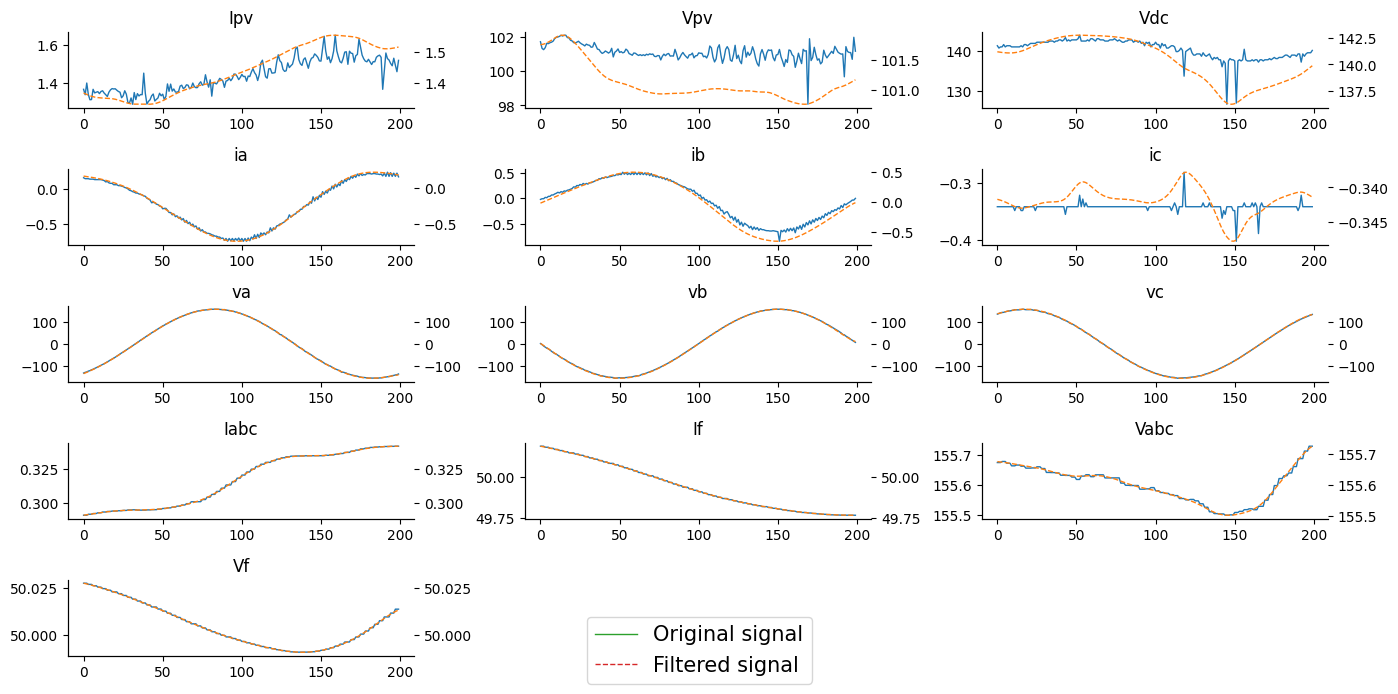

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 7))
axes = axes.flatten()

idx = np.random.randint(X.shape[0])
print(idx)
real = X[idx]
    
feature_columns = ['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'va', 'vb', 'vc', 'Iabc', 'If', 'Vabc', 'Vf']
for j, ticker in enumerate(feature_columns):
    (pd.DataFrame({'Real': real[:, j],
                   'Synthetic': butter_lowpass_filter(real[:, j], cutoff, fs, order)})
    .plot(ax=axes[j],
               title=ticker,
               secondary_y='Synthetic', style=['-', '--'],
               lw=1,
               legend=None))
    line_real, = axes[j].plot([], [], '-', lw=1, label='Original signal')
    line_synthetic, = axes[j].plot([], [], '--', lw=1, label='Filtered signal')
sns.despine()
fig.legend(handles=[line_real, line_synthetic], labels=['Original signal', 'Filtered signal'], loc='lower center', prop={'size': 15})

fig.delaxes(axes[13])
fig.delaxes(axes[14])
#fig.suptitle(f'Fault {label_encoder.inverse_transform([label])[0]}')
fig.tight_layout()

In [9]:
X_filtered = np.empty(shape=X.shape)
n_samples, _, n_features = X.shape
for j in tqdm(range(n_samples)):
    for i in range(n_features):
        X_filtered[j,:,i] = butter_lowpass_filter(X[j,:,i], cutoff, fs, order)

100%|██████████| 72534/72534 [05:08<00:00, 235.21it/s]


In [10]:
def plot(original, filtered):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(14, 7))
    axes = axes.flatten()

    idx = np.random.randint(filtered.shape[0])
    synthetic = filtered[idx]
    real = original[idx]
    
    feature_columns = ['Ipv', 'Vpv', 'Vdc', 'ia', 'ib', 'ic', 'va', 'vb', 'vc', 'Iabc', 'If', 'Vabc', 'Vf']
    for j, ticker in enumerate(feature_columns):
        (pd.DataFrame({'Real': real[:, j],
                   'Synthetic': synthetic[:, j]})
         .plot(ax=axes[j],
               title=ticker,
               secondary_y='Synthetic', style=['-', '--'],
               lw=1,
               legend=None))
        line_real, = axes[j].plot([], [], '-', lw=1, label='Original signal')
        line_synthetic, = axes[j].plot([], [], '--', lw=1, label='Filtered signal')
    sns.despine()
    fig.legend(handles=[line_real, line_synthetic], labels=['Original signal', 'Filtered signal'], loc='lower center', prop={'size': 15})

    fig.delaxes(axes[13])
    fig.delaxes(axes[14])
    #fig.suptitle(f'Fault {label_encoder.inverse_transform([label])[0]}')
    fig.tight_layout()

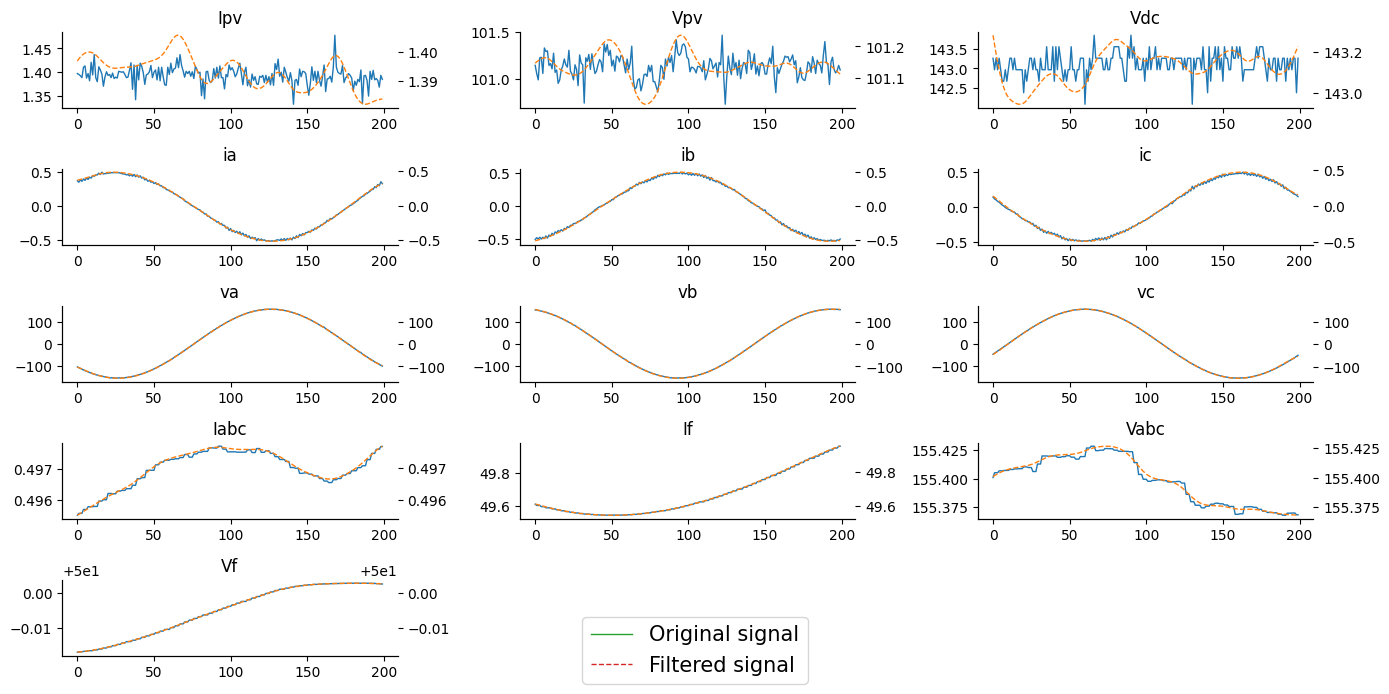

In [11]:
plot(X,X_filtered)

## Dataset split and save

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.33, random_state=42)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(48597, 200, 13) (48597, 1) (23937, 200, 13) (23937, 1)


In [14]:
output_folder = ''

np.save(os.path.join(output_folder, 'X_train.npy'), X_train)
np.save(os.path.join(output_folder, 'y_train.npy'), y_train)
np.save(os.path.join(output_folder, 'X_test.npy'), X_test)
np.save(os.path.join(output_folder, 'y_test.npy'), y_test)